# GFP oracle train-test generalization error estimate, ROC curves and positive predictive values

In [1]:
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import sys
sys.path.append('../src/')
import regressionTools as rt
importlib.reload(rt)

import dataTools as dt
importlib.reload(dt)


### get the right plt style
plt.style.use('../src/paper_style1.mplstyle')
## adding the arial font that had to be downloaded
# following this: https://betterdatascience.com/python-matplotlib-fonts/
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['../src/fonts/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

font_manager.findfont('arial') # font_manager.findfont('Arial') doesn't work
from matplotlib import rcParams
rcParams['font.family'] = 'arial'

In [2]:
dout = '../data/out/'

In [3]:
# get gfp dataset
fin_gfp_exp = '../data/DMS_data/gfp_data.csv'
df_gfp = pd.read_csv(fin_gfp_exp, index_col = 0)
wt_gfp_seq_dms = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK'
df_gfp['hamming_wt'] = df_gfp.mutated_sequence.apply(lambda x: rt.hamming(wt_gfp_seq_dms,x))
df_gfp['oh_code'] = df_gfp.apply(
    lambda r: rt.seq_to_oh(r.mutated_sequence, rt.aa_to_idx), axis=1)


# find the half-maximal DMS score
threshold = (max(df_gfp.DMS_score) - min(df_gfp.DMS_score))/2 + min(df_gfp.DMS_score)
print(threshold)

2.7032641513550004


In [4]:
df_train, df_test = rt.get_df_train_test(df_gfp, train_frac=0.9)

(46542, 5)
(5172, 5)


2023-12-19 15:45:22.091187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/app/gcc/6.2.0/lib64:/n/app/gcc/6.2.0/lib
2023-12-19 15:45:22.091264: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-12-19 15:45:22.091301: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (compute-a-16-162.o2.rc.hms.harvard.edu): /proc/driver/nvidia/version does not exist
2023-12-19 15:45:22.092895: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(4761, 1)
layer0 weights set to:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
beta_hat [0. 0. 0. 0. 0.]


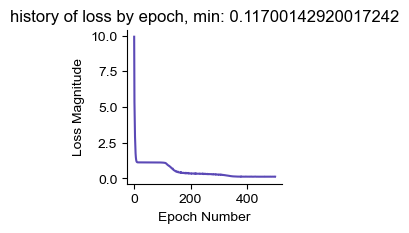

(5172, 4761)
(0.8633838499996331, 0.9304379444530763, 0.869630719958113)


In [5]:
# train on train data
df_train, df_test, model_subset = rt.fit_train_test(
    df_train,
    df_test,
    fit_val='DMS_score',
    oh_col_name='oh_code',
    lr=0.005,
    epochs=500,
    batch_size=1000,
    layer=rt.log_layer_scale_shift(1, reg_strength=0),
    chpt_id=str(
         "gfp_"+ str(int(time.time()))
    )  
)

In [6]:
df_test.to_csv(dout+'df_test_gfp_oracle.csv')

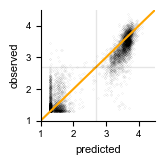

In [24]:
# plot test set predictions
fig = plt.figure(figsize=(1.75,1.75))


plt.scatter(df_test.DMS_score, df_test.yhat_non, s=0.001, c='black')
plt.ylim([1,4.5])
plt.xlim([1,4.5])
plt.xticks([1,2,3,4], fontsize=7)
plt.yticks([1,2,3,4], fontsize=7)
plt.plot([1,5], [1,5], c='orange')

plt.axhline(threshold, c='black', alpha=0.1, lw=1)
plt.axvline(threshold, c='black', alpha=0.1, lw=1)

plt.xlabel('predicted', fontsize=8)
plt.ylabel('observed', fontsize=8)
fig.patch.set_visible(False)
fig.tight_layout()

plt.savefig(dout + 'gfp_pred_vs_obs.png', format='png', dpi=300)

plt.show()

In [19]:
df_yhats_y = pd.DataFrame({'yhat_non': df_test.yhat_non, 'yobs': df_test.DMS_score})


2.7032641513550004


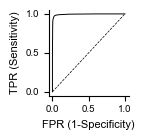

AUC 0.9949146215363593


In [20]:
rt.plot_roc(df_yhats_y, 
            fname = dout + 'ROC_gfp',
           n_thresh=100,
           true_thresh=threshold)

In [21]:
rt.get_ppv(df_yhats_y, threshold=threshold)

PPV is0.9925213675213675


0.9925213675213675

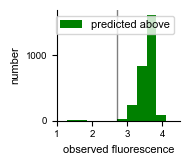

In [23]:
fig = plt.figure(figsize=(2,1.75))

plt.hist(df_yhats_y.loc[df_yhats_y.yhat_non>threshold].yobs, 
        color='green', histtype='stepfilled', label='predicted above', )

plt.xlim([1,4.5])
plt.xticks([1,2,3,4], fontsize=7)

plt.axvline(threshold, c='black', alpha=0.5, lw=1)

plt.xlabel('observed fluorescence', fontsize=8)
plt.yticks([0,1e3], fontsize=7)

plt.ylabel('number', fontsize=8)
plt.legend(fontsize=8)
fig.patch.set_visible(False)
fig.tight_layout()

plt.savefig(dout + 'gfp_half_maximal_pred.svg', format='svg', dpi=300)

plt.show()